## Multiclass Classfifier 성능 비교 (with over-sampling methods)

In [1]:
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
import seaborn as sns
import imblearn
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from imblearn.over_sampling import ADASYN 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
#데이터가 실행 코드와 동일 폴더에 위치함을 가정한다

from pandas import read_csv

df = read_csv('glass.csv', header=None)
print(df.shape)

(214, 10)


In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


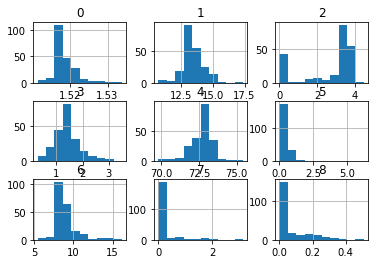

In [5]:
df[range(0,9)].hist()
plt.show()

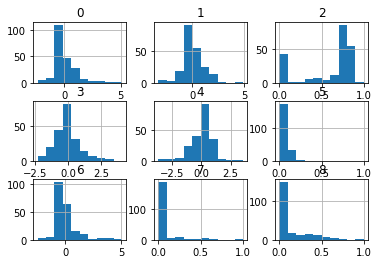

In [6]:
# 위의 분포로 보아 두가지 종류로  standardization을 한다

mm=MinMaxScaler()
ss=StandardScaler()
df[[0,1,3,4,6]]=ss.fit_transform(df[[0,1,3,4,6]])
df[[2,5,7,8]] = mm.fit_transform(df[[2,5,7,8]])

df[range(0,9)].hist()
plt.show()

Class=1, n=70 (32.71%)
Class=2, n=76 (35.51%)
Class=3, n=17 (7.94%)
Class=5, n=13 (6.07%)
Class=6, n=9 (4.21%)
Class=7, n=29 (13.55%)


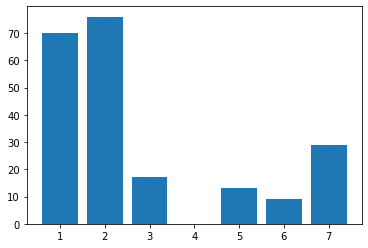

In [7]:
#타겟의 불균형 정도를 파악
data=df.values
X, y = data[:, :-1], data[:, -1]

# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.2f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()


#향후 SMOTE와 Adasyn을 통해 오버샘플링을 진행할 것
#LabelEncoder를 통해 없는 타겟 변수는 지워줄 것이다.

Class=0, n=76 (16.67%)
Class=1, n=76 (16.67%)
Class=2, n=76 (16.67%)
Class=3, n=76 (16.67%)
Class=4, n=76 (16.67%)
Class=5, n=76 (16.67%)


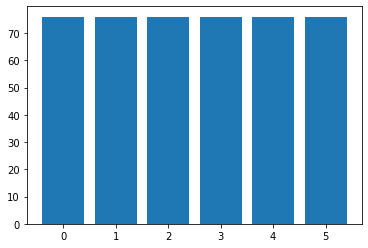

In [8]:
#존재하지 않는 타겟 변수를 삭제하고 소수 클래스를 증강하면 다음과 같은 분포를 보일 것이다.

from imblearn.over_sampling import SMOTE

# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.2f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [9]:
# 데이터셋 준비. test_size는 20%만 hold-out 한다.
# 분리 후 각 데이터셋의 크기는 다음과 같다

from sklearn.model_selection import train_test_split

X, y = data[:, :-1], data[:, -1]
y = LabelEncoder().fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 77)
print(len(X_train))
print(len(X_test))

171
43


>SVM 0.678 (0.103)
>KNN 0.660 (0.145)
>RF 0.801 (0.110)


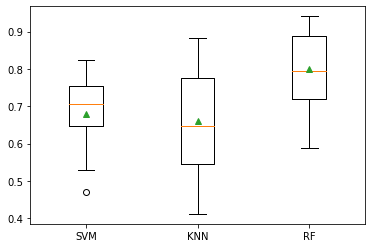

In [10]:
# SVM의 SVC, KMeans, RandomForest 각 모델에 대해 타겟 불균형 상태로 accuracy를 파악한다.
#각 분류기는 분류 정확성을 높이기 데이터셋과 오버샘플링에 따른 대략적인 성능을 보고자 함이라서 
# sklearn의 default 값으로 세팅하였다.

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

 
names=['SVM','KNN','RF']
models=[]

X, y = data[:, :-1], data[:, -1]
y = LabelEncoder().fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 77)
 
# define models to test

svm = SVC(gamma='auto')
models.append(svm)
	# KNN
KNN = KNeighborsClassifier()
models.append(KNN)

# RF
RF=RandomForestClassifier(n_estimators=1000)
models.append(RF)

results = list()
# evaluate each model
for i,model in enumerate(models):
	# evaluate the model and store results
	model.fit(X_train,y_train)
	scores = cross_val_score(estimator=model, X=X_train, y=y_train, cv=10)
	results.append(scores)
	# summarize performance
	print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

>SVM 0.558 (55.814)
>KNN 0.628 (62.791)
>RF 0.767 (76.744)


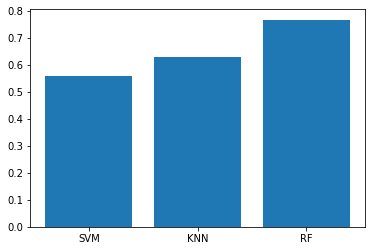

In [11]:
# test data에 대한 경우

test_results = list()

for i, model in enumerate(models):
    	# evaluate the model and store results
	#y_pred = model.predict(X_test)
	acc=model.score(X_test,y_test)
	test_results.append(acc)
	# summarize performance
	print('>%s %.3f (%.3f)' % (names[i],acc, acc*100 ))
# plot the results
plt.bar(names,test_results)
plt.show()

In [12]:
## 오버샘플링을 하지 않은 경우, 세 모델 모두 성능이 좋지 않은 것으로 보인다.
## 그중에서는 RF 모델이 상대적으로 우수하다.

>SVM 0.830 (0.081)
>KNN 0.855 (0.062)
>RF 0.915 (0.064)


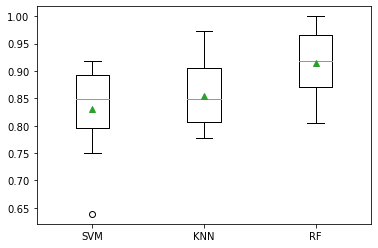

In [13]:
## 세 모델에 대한 SMOTE oversampling을 시도한다.
## Training Set에 대하여
X, y = data[:, :-1], data[:, -1]
oversample = SMOTE(k_neighbors = 3)
y=LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.20, random_state = 77)
X_train, y_train = oversample.fit_resample(X_train, y_train)

results = list()

# evaluate each model
for i,model in enumerate(models):
	# evaluate the model and store results
	model.fit(X_train,y_train)
	scores = cross_val_score(estimator=model, X=X_train, y=y_train, cv=10)
	results.append(scores)
	# summarize performance
	print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

>SVM 0.535 (53.488)
>KNN 0.721 (72.093)
>RF 0.767 (76.744)


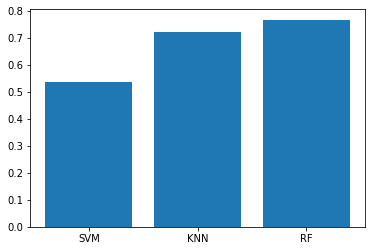

In [14]:
# Test Set에 대한 경우

test_results = list()

for i, model in enumerate(models):
    	# evaluate the model and store results
	#y_pred = model.predict(X_test)
	acc=model.score(X_test,y_test)
	test_results.append(acc)
	# summarize performance
	print('>%s %.3f (%.3f)' % (names[i],acc, acc*100 ))
# plot the results
plt.bar(names,test_results)
plt.show()

#smote에 의한 오버샘플링을 하지 않은 경우 보다 개선되었으나, test data와의 accuracy 차기 많이 존재한다.

>SVM 0.774 (0.068)
>KNN 0.756 (0.104)
>RF 0.849 (0.077)


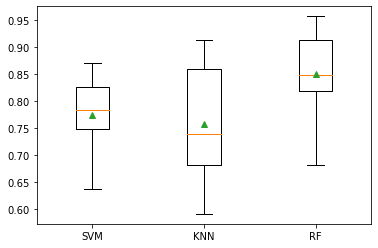

In [15]:
## 세 모델에 대한 Adasyn oversampling을 시도한다.
## Training Set에 대하여

from imblearn.over_sampling import ADASYN 

ada = ADASYN(sampling_strategy='minority',n_neighbors=3)
X, y = data[:, :-1], data[:, -1]

y=LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.20, random_state = 77)
X_train, y_train = ada.fit_resample(X_train, y_train)

results=[]
for i,model in enumerate(models):
    	# evaluate the model and store results
	model.fit(X_train,y_train)
	scores = cross_val_score(estimator=model, X=X_train, y=y_train, cv=10)
	results.append(scores)
	# summarize performance
	print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show()


>SVM 0.605 (60.465)
>KNN 0.698 (69.767)
>RF 0.767 (76.744)


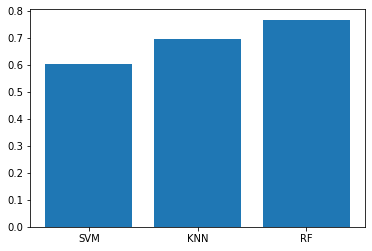

In [16]:
# test data에 대한 경우

test_results = list()

for i, model in enumerate(models):
    # evaluate the model and store results
	#y_pred = model.predict(X_test)
	acc=model.score(X_test,y_test)
	test_results.append(acc)
	# summarize performance
	print('>%s %.3f (%.3f)' % (names[i],acc, acc*100 ))
# plot the results
plt.bar(names,test_results)
plt.show()

#smote에 비해 training accuracy는 낮지만, test set accuracy는 상대적으로 높다

In [17]:
# 종합: adasyn 오버샘플링을 적용한 RF의 성능이 가장 우수한 것으로 판단된다

In [22]:
#Neural Model에 의한 multilabe classification

#우선 데이터셋의 크기가 매우 작으므로, 심층신경망은 잘 작동하지 않을 것으로 예상되나 일단 그 확인을 위해
# Training Set과 Test Set 을 나누지 않고 전체를 대상으로 베이스라인을 확인한다.

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.pipeline import Pipeline

# split into input and output elements
X, y = data[:, :-1], data[:, -1]

ada = ADASYN(sampling_strategy='minority', n_neighbors=3)
X, y = ada.fit_resample(X, y)
y = LabelEncoder().fit_transform(y)

 
# define baseline model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(128, input_dim=9, activation='relu'))
	model.add(Dense(64, input_dim=128, activation='relu'))
	model.add(Dense(32, input_dim=64, activation='relu'))
	model.add(Dense(6, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
model=baseline_model()
estimator = KerasClassifier(build_fn=baseline_model, epochs=100, batch_size=16, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Baseline Model Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline Model Accuracy: 78.93% (6.07%)


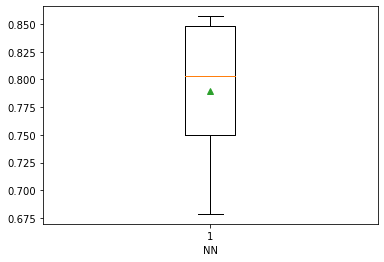

In [23]:
#위 시범 모델에 대한 accuracy의 분포는 다음과 같다

label='NN'
plt.boxplot(results,labels=None,showmeans=True)
plt.xlabel('NN')
plt.show()

#### 아래 세가지의 심층신경망들은 모두 L2정규화와 드롭아웃 0.5로 세팅하였고, 
#### 10 fold로 학습과정의 acc를 확인하였다.

In [20]:
#심층 신경망에 대해 오버샘플링을 하지 않은 모델

from tensorflow import keras
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical
kfold = KFold(n_splits=10, shuffle=True, random_state=77)
cvscores = []
X, y = data[:, :-1], data[:, -1]
y = LabelEncoder().fit_transform(y)
y=to_categorical(y, num_classes=6, dtype='float32')
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.20, random_state = 77)
  # create model
acc_per_fold=[]

for train, val in kfold.split(X_train, y_train):
	model = Sequential()
	model.add(Dense(128, input_dim=9, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
	keras.layers.Dropout(0.5),
	model.add(Dense(64, input_dim=128, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
	keras.layers.Dropout(0.5),
	model.add(Dense(32, input_dim=64, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
	keras.layers.Dropout(0.5),
	model.add(Dense(6, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# Fit the model
	model.fit(X_train[train], y_train[train], epochs=100, batch_size=16, verbose=0)
	# evaluate the model
	scores = model.evaluate(X_train[val], y_train[val], verbose=0)
	
	acc_per_fold.append(scores[1] * 100)
	
print("Mean of training accuracy : {:.3f}%".format(np.mean(acc_per_fold)))



Mean of training accuracy : 70.261%


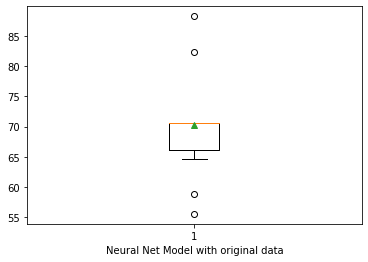

In [21]:
#위 모델의 분포는 아래와 같다

plt.boxplot(acc_per_fold,labels=None,showmeans=True)
plt.xlabel('Neural Net Model with original data')
plt.show()

In [24]:
test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy : {:.3f}%".format(test_acc[1]*100))

Test Accuracy : 20.930%


In [25]:
#뉴럴넷 with smote

kfold = KFold(n_splits=5, shuffle=True, random_state=77)
cvscores = []
X, y = data[:, :-1], data[:, -1]

oversample = SMOTE(k_neighbors=3)

y = LabelEncoder().fit_transform(y)
y=to_categorical(y, num_classes=6, dtype='float32')
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.20, random_state = 77)

X_train, y_train = oversample.fit_resample(X_train, y_train)

acc_per_fold=[]

for train, val in kfold.split(X_train, y_train):
	model = Sequential()
	model.add(Dense(128, input_dim=9, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
	keras.layers.Dropout(0.5),
	model.add(Dense(64, input_dim=128, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
	keras.layers.Dropout(0.5),
	model.add(Dense(32, input_dim=64, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
	keras.layers.Dropout(0.5),
	model.add(Dense(6, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# Fit the model
	model.fit(X_train[train], y_train[train], epochs=100, batch_size=16, verbose=0)
	# evaluate the model
	scores = model.evaluate(X_train[val], y_train[val], verbose=0)
	
	acc_per_fold.append(scores[1] * 100)	
 
print("Mean of Train Accuracy : {:.3f}%".format(np.mean(acc_per_fold)))


Mean of Train Accuracy : 87.434%


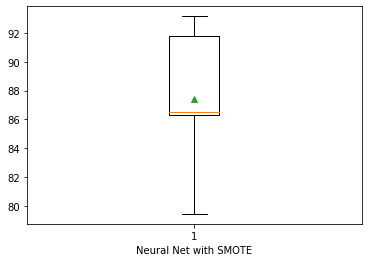

In [26]:
plt.boxplot(acc_per_fold,labels=None,showmeans=True)
plt.xlabel('Neural Net with SMOTE')
plt.show()

In [27]:
test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy : {:.3f}%".format(test_acc[1]*100))

Test Accuracy : 74.419%


In [28]:
#Neural Net with Adasyn

kfold = KFold(n_splits=10, shuffle=True, random_state=77)
cvscores = []
X, y = data[:, :-1], data[:, -1]

ada = ADASYN(sampling_strategy='minority',n_neighbors=3)

y = LabelEncoder().fit_transform(y)
y=to_categorical(y, num_classes=6, dtype='float32')
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.20, random_state = 77)
X_train, y_train = ada.fit_resample(X_train, y_train)

acc_per_fold=[]

for train, val in kfold.split(X_train, y_train):
	model = Sequential()
	model.add(Dense(128, input_dim=9, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
	keras.layers.Dropout(0.5),
	model.add(Dense(64, input_dim=128, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
	keras.layers.Dropout(0.5),
	model.add(Dense(32, input_dim=64, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
	keras.layers.Dropout(0.5),
	model.add(Dense(6, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# Fit the model
	model.fit(X_train[train], y_train[train], epochs=100, batch_size=16, verbose=0)
	# evaluate the model
	scores = model.evaluate(X_train[val], y_train[val], verbose=0)
	
	acc_per_fold.append(scores[1] * 100)
	
print("Mean of Train Accuracy : {:.3f}%".format(np.mean(acc_per_fold)))



Mean of Train Accuracy : 75.771%


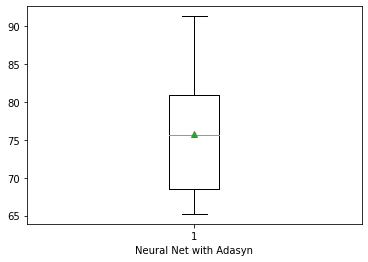

In [29]:
plt.boxplot(acc_per_fold,labels=None,showmeans=True)
plt.xlabel('Neural Net with Adasyn')
plt.show()

In [30]:
test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy : {:.3f}%".format(test_acc[1]*100))

Test Accuracy : 76.744%


### 결론 

뉴럴넷에 adasyn을 적용한 모델이 가장 test acc가 높았다.
그러나 고전적 ML 모델은 물론 NN 모델 모두 하이퍼 파라미터 fine-tuning을 하지 않은 상태이므로, 
단순 비교는 지양할 필요가 있다.

다만, SVM은 본 보고의 데이터 셋과 같은 작은 데이터셋에 잘 작용하지 않는 것으로 보였다.
데이터셋과 관련해서는, "하지 않은 경우" < Smote < Adasyn 의 순서로 보이나, 각 모델별로 차이가 있다.


## 중요

#### 오버샘플링을 할 경우, 반드시 train data와 test data를 나눈 후, train data에 대해서만 해야 함
#### 그렇지 않고 만약 test data에도 오버샘플링을 할 경우, 비정상적으로 test accuracy가 높게 나옴
#### test data에도 오버샘플링을 할 경우 training 과정에서 이미 목격된 데이터가 test set에도 존재할 가능성이 커지기 때문임